In [51]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt


#Agent的行動
class Actions(Enum):
    Sell = 0
    Buy = 1

#在Env裡面所代表的
class Positions(Enum):
    Short = 0
    Long = 1

    def opposite(self):
        return Positions.Short if self == Positions.Long else Positions.Long

    
class TradingEnv(gym.Env):

    metadata = {'render.modes': ['human']}
    
    #__init__為魔法函數，意義為：無論你願不願意，只要你執行TradingEnv，就會把__init__底下的資料執行，可以用作變數定義？
    def __init__(self, df, window_size): 
        assert df.ndim == 2 #判斷所輸入的df維度是否等於2

        self.seed() #隨機種子設定
        self.df = df #輸入df
        self.window_size = window_size #輸入Windows size
        self.open, self.close, self.high, self.low, self.volume, self.signal_features = self._process_data() #輸入【價錢, 特征資料】
        self.shape = (window_size, 2, 2) #輸入【Windows size, 2, 2】

        # spaces
        self.action_space = spaces.Discrete(len(Actions)) # 行動空間為：2（Sell、Buy）
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float64) #觀察空間最低和最高為無限（因為不知股票價錢為多少）

        # episode
        #「_」為私有化，即import的時候不會引入參數
        self._start_tick = self.window_size #開始日期：Windows_size設定的數字
        self._end_tick = len(self.close)-1 #結束日期：【價錢】的長度-1
        self._done = None 
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓        
        self._reward_history = []#記錄Reward獎勵，方便畫圖
        self._Total_profit = []#記錄Profit，方便畫圖
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None

    #定義一個隨機種子   
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    #重設
    def reset(self):
        self._done = False #尚未完成
        self._current_tick = self._start_tick # Windows_size設定的數字
        self._last_trade_tick = self._current_tick -1 #Windows_size設定的數字-1
        self._position = Positions.Short #第一天交易必定為Short
        self._position_history = (self.window_size * [None]) + [self._position] #記錄位置
        self._total_reward = 0. #初始化的reward為：0
        self._total_profit = 1. #初始化的Profit為：1
        self._first_rendering = True
        self.history = {}
        return self._get_observation()

    #交易中的步驟
    def step(self, action):
        self._done = False #尚未完成動作
        
        
        #如果當前日期 = 完結日期，就結束步驟
        if self._current_tick == self._end_tick:
            self._done = True

#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
#如果機器人進行買的動作，他的Position就會變成Long，反之亦然
        if(action == Actions.Buy.value):
            self._position = Positions.Long
#             print("action: ", action)
#             print("position: ", self._position)
        elif(action == Actions.Sell.value):
            self._position = Positions.Short
#             print("action: ", action)
#             print("position: ", self._position)
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑               
        self._last_trade_tick = self._current_tick      
        #記錄步驟
        self._position_history.append(self._position)
        
        #獎勵：調用計算獎勵的function，然後將它累積起來計算總和
        step_reward = self._calculate_reward(action)
        step_profit = self._update_profit(action)#記錄profit，方便畫圖
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
        self._reward_history.append(step_reward)#記錄Reward獎勵，方便畫圖
        self._Total_profit.append(step_profit)#記錄profit，方便畫圖
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ 
        self._total_reward += step_reward
        #根據agent的action更新他的 profit
        
        
        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
            position = self._position.value
        )
        self._update_history(info)
        
        self._current_tick += 1 #當前日期+1

        return observation, step_reward, self._done, info

    #取得觀察值，觀察值為signal_features
    #若window_size為10
    #則使用0 ~ 9日的觀察值，下一次交易則使用1 ~ 10日的觀察值
    def _get_observation(self):
        return self.signal_features[(self._current_tick-self.window_size+1):self._current_tick+1]

    #更新歷史資料
    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)

    #render：將環境實體化，以股票交易為例即是畫圖
    def render(self, mode='human'):
        pass


    #畫圖
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓    
    def render_Close(self, mode='human'):
            window_ticks = np.arange(len(self._position_history))#[1,2,3,4,5,....]矩陣
            plt.plot(self.close)#根據收盤價進行繪畫

            short_ticks = []
            long_ticks = []
            # i：控制position_history的位置
            # tick：控制要塞進Long還是Short的位置
            #如果機器人在之前就是做Long的話就把它記錄在long_ticks裡面，反之亦然
            for i, tick in enumerate(window_ticks-1):
                if self._position_history[i] == Positions.Short:
                    short_ticks.append(tick)
                elif self._position_history[i] == Positions.Long:
                    long_ticks.append(tick)      

            del(short_ticks[0])

            plt.plot(short_ticks, self.close[short_ticks], 'ro', label = 'Short')#根據收盤價進行畫圖
            plt.plot(long_ticks, self.close[long_ticks], 'go', label = 'Long')#根據收盤價進行畫圖
            
            plt.legend()
            plt.title("Close", fontsize=20)
            plt.suptitle(
                "Total Reward: %.6f" % self._total_reward + ' ~ ' +
                "Total Profit: %.6f" % self._total_profit
            )
            print("↓↓↓ 台積電(2330)在交易當天收盤時進行的交易策略(Long Or Short) ↓↓↓")
        
        
    #畫圖2   
    def render_Reward(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        short_ticks = []
        long_ticks = []
        for i, tick in enumerate(window_ticks-1):
            if self._position_history[i] == Positions.Short:
                short_ticks.append(tick)
            elif self._position_history[i] == Positions.Long:
                long_ticks.append(tick)
        
        del(short_ticks[0])
        self._reward_history = np.array(self._reward_history)
        short_ticks = (np.array(short_ticks)-5).tolist()
        long_ticks = (np.array(long_ticks)-5).tolist()
        
        plt.bar(short_ticks,self._reward_history[short_ticks], color='r', label = 'Short')#根據獎勵進行繪畫
        plt.bar(long_ticks,self._reward_history[long_ticks], color='g', label = 'Long')#根據獎勵進行繪畫
            
        plt.legend()   
        plt.title("Reward", fontsize=20)
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        print("↓↓↓ 台積電(2330)在使用交易策略(Long Or Short)後，隔日早上平倉時的盈虧(未含手續費) ↓↓↓")
        
        
    def render_TotalProfit(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        
        del self._Total_profit[-1]
        plt.plot(self._Total_profit)
        
        
#         short_ticks = []
#         long_ticks = []
#         for i, tick in enumerate(window_ticks-1):
#             if self._position_history[i] == Positions.Short:
#                 short_ticks.append(tick)
#             elif self._position_history[i] == Positions.Long:
#                 long_ticks.append(tick)
        
#         del(short_ticks[0])
#         self._Total_profit = np.array(self._Total_profit)
#         short_ticks = (np.array(short_ticks)-10).tolist()
#         long_ticks = (np.array(long_ticks)-10).tolist()
        
#         plt.plot(short_ticks, self._Total_profit[short_ticks], 'ro', label = 'Short')#根據獎勵進行畫圖
#         plt.plot(long_ticks, self._Total_profit[long_ticks], 'go', label = 'Long')#根據獎勵進行畫圖
            
#         plt.legend() 

        plt.title("TotalProfit", fontsize=20)
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        print("↓↓↓ 根據預測出的交易策略交易台積電(2330)，所得到的累積利潤(含手續費) ↓↓↓")

        
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑         
        


    
    
    #關閉環境，即關閉畫圖    
    def close(self):
        plt.close()

    #保存圖片
    def save_rendering(self, filepath):
        plt.savefig(filepath)

    #暫停畫圖
    def pause_rendering(self):
        plt.show()

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _process_data(self):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _calculate_reward(self, action):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _update_profit(self, action):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def max_possible_profit(self):  # trade fees are ignored
        pass

In [52]:
import numpy as np

class StocksEnv(TradingEnv):
    

    def __init__(self, df, window_size, frame_bound):
        assert len(frame_bound) == 2 #判斷所輸入的df維度是否等於2

        self.frame_bound = frame_bound #輸入範圍值
        super().__init__(df, window_size)

        self.trade_fee_percent = 0.001425+0.003
        #https://rich01.com/what-is-next-day-trading/
        
    #資料處理
    def _process_data(self):
        open = self.df.loc[:, 'open'].to_numpy() #prices：開市價
        close = self.df.loc[:, 'close'].to_numpy() #prices：收盤價
        high = self.df.loc[:, 'high'].to_numpy() #prices：最高
        low = self.df.loc[:, 'low'].to_numpy() #prices：最低
        volume = self.df.loc[:, 'volume'].to_numpy() #prices：成交量
        close[self.frame_bound[0] - self.window_size] # validate index (TODO: Improve validation)#驗證資料：10-10
        close = close[self.frame_bound[0]-self.window_size:self.frame_bound[1]]#【10-10:5600】

        diff = np.insert(np.diff(close), 0, 0)#計算價差【今天 - 昨天】
        signal_features = np.column_stack((close, diff))#默認的signal_features為：收盤價，價差

        return open, close ,high, low, volume, signal_features

#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
    #計算獎勵
    def _calculate_reward(self, action):
        step_reward = 0
        price_diff = 0
        
        if(self._current_tick < self._end_tick):
            if(action == Actions.Buy.value):
                current_price = self.close[self._current_tick]#【今天收盤】
                last_trade_price = self.open[self._current_tick+1]#【明天開盤】
                price_diff = last_trade_price - current_price#【明天開盤 - 今天收盤】

            elif(action == Actions.Sell.value):
                current_price = self.close[self._current_tick]#【今天收盤】
                last_trade_price = self.open[self._current_tick+1]#【明天開盤】
                price_diff = -(last_trade_price - current_price)#【-(明天開盤 - 今天收盤)】
        
        step_reward =  step_reward + price_diff
        
        return step_reward


    def _update_profit(self, action):
        
        long_profit_percentage = 0.0
        short_profit_percentage = 0.0
        Total_long_profit_percentage = 0.0
        Total_short_profit_percentage = 0.0
        
        step_profit = 0
        if(self._current_tick < self._end_tick):
            if(action == Actions.Buy.value):
                current_price = self.close[self._current_tick]#【今天收盤】
                last_trade_price = self.open[self._current_tick+1]#【明天開盤】
                long_profit_percentage = ((last_trade_price - current_price)/current_price) - self.trade_fee_percent
                self._total_profit += long_profit_percentage
            elif(action == Actions.Sell.value):

                current_price = self.close[self._current_tick]#【今天收盤】
                last_trade_price = self.open[self._current_tick+1]#【明天開盤】
                short_profit_percentage = ((-(last_trade_price - current_price)) / current_price) - self.trade_fee_percent
                self._total_profit += short_profit_percentage   
                
        step_profit += self._total_profit #記錄profit，方便畫圖
        return step_profit#記錄profit，方便畫圖
        
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑  
                
    #https://github.com/AminHP/gym-anytrading/blob/master/README.ipynb
    #不論交易費用如何，agent在股票交易中所獲得的profit
    def max_possible_profit(self):
        pass

In [53]:
# import gym_anytrading
import numpy as np
import pandas as pd
import quantstats as qs
from stable_baselines import A2C

In [54]:
from yahoo_fin import stock_info as si
from sklearn.preprocessing import Normalizer
if isinstance('2330.TW', str):
    # load it from yahoo_fin library
    df = si.get_data('2330.TW')
df = df.dropna()#丟棄空值
df = df.reset_index()

#---------------------------------------------------------------------------
#定義參數

open = df['open']
close = df['close']
high = df['high']
low = df['low']
UpLine_max = []
UpLine = [] #上引線
DownLine_min = []
DownLine = [] #下引線
UpMean_5Day = []#計算RSI——上漲平均5天
DownMean_5Day = []#計算RSI——下跌平均5天
RSI_5Day = []#計算RSI
#---------------------------------------------------------------------------
#上引線；下引線

for i in range(close.size):
    UpLine_max.append(max(open[i], close[i]))
for i in range(close.size):
    UpLine.append(high[i] - UpLine_max[i])#上影線
for i in range(close.size):
    DownLine_min.append(min(open[i], close[i]))
for i in range(close.size):
    DownLine.append(DownLine_min[i] - low[i])#下影線
#---------------------------------------------------------------------------
#RSI

UpDownValue = close - close.shift(1) #計算漲跌值
Only_UpValue = pd.Series(index=UpDownValue.index, data=UpDownValue[UpDownValue>0])#將上漲日子篩出
Only_UpValue = Only_UpValue.fillna(0)#下跌的日子為0
Only_DownValue = pd.Series(index=UpDownValue.index, data=-UpDownValue[UpDownValue<0])#將下跌日子篩出
Only_DownValue = Only_DownValue.fillna(0)#上漲的日子為0
for i in range(13, len(Only_UpValue)+1):#由第六日開始，直到現在
    UpMean_5Day.append(np.mean(Only_UpValue.values[i-12:i]))#計算出最近五日的平均，因為有補0，所以可以計算出。
    DownMean_5Day.append(np.mean(Only_DownValue.values[i-12:i]))#計算出最近五日的平均
for i in range(len(UpMean_5Day)):
    RSI_5Day.append( (UpMean_5Day[i] / ( UpMean_5Day[i] + DownMean_5Day[i] )) * 100  )#計算RSI
RSI_5Day = pd.Series(index = close.index[12:], data = RSI_5Day) #轉換格式
#---------------------------------------------------------------------------
#FH；FL
FH = ((high - open) / open) #FH
FL = ((open - low) / open) #FL
FH = pd.DataFrame(FH, columns=['FH'])#FH參數
FL = pd.DataFrame(FL, columns=['FL'])#FL參數
#---------------------------------------------------------------------------
# KD
K = []
D = []
K_Value = []
D_Value = []
def RSV(df):
    df['MinLow'] = df['low'].rolling(9, min_periods=9).min()#9天最低位
    df['MinLow'].fillna(value = df['low'].expanding().min(), inplace = True)#填滿NA
    df['MaxHigh'] = df['high'].rolling(9, min_periods=9).max()#9天最高位
    df['MaxHigh'].fillna(value = df['high'].expanding().max(), inplace = True)#填滿NA
    df['RSV'] = (df['close'] - df['MinLow']) / (df['MaxHigh'] - df['MinLow']) * 100 #計算RSV
    return df
RSV_df = RSV(df)#使用RSV函數計算
RSV = RSV_df['RSV']#獲得RSV
for i in range(len(RSV)):
    if i<=9 :
        K.append(50)
        D.append(50)
    elif i > 9:
        K.append((K[i-1] * 2/3) + (1/3 * RSV[i]))
        D.append((D[i-1] * 2/3) + (1/3 * K[i]))
K_Value = pd.Series(index = close.index[0:], data = K) #轉換格式
D_Value = pd.Series(index = close.index[0:], data = D) #轉換格式
#---------------------------------------------------------------------------
# MACD
DIF = []
MACD = []
ShortEMA=close.ewm(span=12,adjust=False).mean()#12日移動平均
LongEMA=close.ewm(span=26,adjust=False).mean()#26日移動平均
FastLine_DIF=ShortEMA-LongEMA#DIF = （12日移動平均 - 26日移動平均）
SlowLine_MACD=FastLine_DIF.ewm(span=9,adjust=False).mean()#取DIF數值得到9日移動平均
FastLine_DIF = pd.DataFrame(FastLine_DIF)#轉換格式
SlowLine_MACD = pd.DataFrame(SlowLine_MACD)#轉換格式
FastLine_DIF = FastLine_DIF.rename(columns={'close':'DIF'})#轉換格式
SlowLine_MACD = SlowLine_MACD.rename(columns={'close':'MACD'})#轉換格式
#---------------------------------------------------------------------------                                                             
#BBands
def BBands(df,Day=20,Times=2):#20天平均, 2倍標準差
    Up_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    Mid_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    Down_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    SD=pd.Series(0.0,index=df.index)#建立全0的陣列
    
    for i in range(Day-1,len(df)):#19~5600   
        Mid_Track[i]=np.mean(df[i-(Day-1):(i+1)])#中軌 = 0-20平均 -> 1-21平均 -> 2-22平均...（移動平均線）
        SD[i]=np.std(df[i-(Day-1):(i+1)])#0-20標準差 -> 1-21標準差 ->2-22標準差...（標準差）
        Up_Track[i]=Mid_Track[i]+(Times*SD[i])#上軌 = 中軌+（2倍標準差）
        Down_Track[i]=Mid_Track[i]-(Times*SD[i])#下軌 = 中軌-（2倍標準差）
        
        #慢慢地將上半部分建立的全0函式更新
        df_BBands=pd.DataFrame({'Up_Track':Up_Track[(Day-1):],#由第19日開始載入布林通道（上）
                             'Mid_Track':Mid_Track[(Day-1):],#由第19日開始載入布林通道（中）
                             'Down_Track':Down_Track[(Day-1):]#由第19日開始載入布林通道（下）
                            })
    return(df_BBands)
BBands_Up_Mid_Down_Trak = BBands(close, 20, 2)
#---------------------------------------------------------------------------
#合拼df
df2330 = pd.merge(df, FH,left_index=True,right_index=True) #合拼FH
df2330 = pd.merge(df2330, FL,left_index=True,right_index=True) #合拼FL
df2330 = pd.merge(df2330, pd.DataFrame(UpLine, columns=['UpLine']),left_index=True,right_index=True) #合併上影線
df2330 = pd.merge(df2330, pd.DataFrame(DownLine, columns=['DownLine']),left_index=True,right_index=True) #合併下影線
df2330 = pd.merge(df2330, pd.DataFrame(RSI_5Day, columns=['RSI_5Day']),left_index=True,right_index=True) #合併RSI
df2330 = pd.merge(df2330, pd.DataFrame(K_Value, columns=['K_Value']),left_index=True,right_index=True) #合併K值
df2330 = pd.merge(df2330, pd.DataFrame(D_Value, columns=['D_Value']),left_index=True,right_index=True) #合併D值
df2330 = pd.merge(df2330, pd.DataFrame(FastLine_DIF),left_index=True,right_index=True) #合併DIF
df2330 = pd.merge(df2330, pd.DataFrame(SlowLine_MACD),left_index=True,right_index=True) #合併MACD
df2330 = pd.merge(df2330,BBands_Up_Mid_Down_Trak,left_index=True,right_index=True) #合併布林通道
df2330.index = range(len(df2330))#更新index

# 是否將特徵資料標準化？

In [55]:
#---------------------------------------------------------------------------
# normalizer = Normalizer()#創建標準化函數
# df2330_AllFeatures = df2330[['MinLow','MaxHigh','RSV','FH','FL','UpLine','DownLine','RSI_5Day','K_Value','D_Value','DIF','MACD','Up_Track','Mid_Track','Down_Track']]#取得需要標準化的特徵
# df2330_FeaturesNormalize = normalizer.fit_transform(df2330_AllFeatures)#進行標準化
# df2330_FeaturesNormalize = pd.DataFrame(df2330_FeaturesNormalize)#將array變成df
# df2330_FeaturesNormalize = df2330_FeaturesNormalize.rename(columns={0:'MinLow',1:'MaxHigh',2:'RSV',
#                                                       3:'FH',4:'FL',
#                                                       5:'UpLine',6:'DownLine',
#                                                       7:'RSI_5Day',
#                                                       8:'K_Value',9:'D_Value',
#                                                       10:'DIF',11:'MACD',
#                                                       12:'Up_Track',13:'Mid_Track',14:'Down_Track'})#更改名字
# df2330_OriginData = df2330[['index','open','high','low','close','adjclose','volume','ticker']]#取得市場基本資料
# df2330_Normalized = pd.merge(df2330_OriginData, df2330_FeaturesNormalize, left_index=True,right_index=True) #基本資料與標準化後特徵資料合併
# df2330 = df2330_Normalized
#---------------------------------------------------------------------------

#---------------------------------------------------------------------------
#輸出最終Dataframe
df2330

,index,open,high,low,close,adjclose,volume,ticker,MinLow,MaxHigh,...,UpLine,DownLine,RSI_5Day,K_Value,D_Value,DIF,MACD,Up_Track,Mid_Track,Down_Track
0,2000-01-31,77.474449,79.822517,77.083290,79.430984,40.830643,1.680593e+11,2330.TW,70.822884,82.561378,...,0.391533,0.391159,77.776839,80.227992,79.952133,2.537185,1.570528,81.099125,73.014005,64.928886
1,2000-02-01,80.213676,80.213676,78.648293,79.039825,40.629574,1.530819e+11,2330.TW,70.822884,82.561378,...,0.000000,0.391533,73.809359,76.818648,78.907638,2.584686,1.773359,81.819298,73.483545,65.147792
2,2000-02-02,79.039825,79.039825,79.039825,79.039825,40.629574,0.000000e+00,2330.TW,71.214043,82.561378,...,0.000000,0.000000,70.269927,74.201038,77.338771,2.592447,1.937177,82.478129,73.874834,65.271540
3,2000-02-03,79.039825,79.039825,79.039825,79.039825,40.629574,0.000000e+00,2330.TW,73.170578,82.561378,...,0.000000,0.000000,76.470065,70.300682,74.992741,2.568984,2.063538,82.998780,74.344374,65.689967
4,2000-02-04,79.039825,79.039825,79.039825,79.039825,40.629574,0.000000e+00,2330.TW,74.344429,82.561378,...,0.000000,0.000000,76.470065,65.914727,71.966737,2.521325,2.155096,83.228655,74.911740,66.594826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5644,2022-09-06,488.500000,491.500000,486.500000,489.000000,489.000000,1.670028e+07,2330.TW,484.000000,515.000000,...,2.500000,2.000000,29.729730,11.983110,15.340397,-3.687249,-0.193505,532.326939,506.700000,481.073061
5645,2022-09-07,477.000000,478.000000,472.000000,472.500000,472.500000,3.467856e+07,2330.TW,472.000000,515.000000,...,1.000000,0.500000,26.347305,8.376337,13.019044,-5.406335,-1.236071,534.890647,505.325000,475.759353
5646,2022-09-08,473.000000,475.000000,472.000000,475.000000,475.000000,2.793155e+07,2330.TW,472.000000,505.000000,...,0.000000,1.000000,31.410256,8.614527,11.550872,-6.492155,-2.287288,535.434125,503.375000,471.315875
5647,2022-09-12,485.000000,491.000000,485.000000,486.500000,486.500000,2.159721e+07,2330.TW,472.000000,505.000000,...,4.500000,0.000000,40.677966,20.389483,14.497075,-6.351506,-3.100131,534.072818,501.850000,469.627182


# 查找DF的標籤

In [56]:
dfStartDate_Train = df2330[(df2330['index']=='2007-01-02')].index.values
dfStartDate_Train = dfStartDate_Train[0]
dfStartDate_Train

1793

In [57]:
dfEndDate_Train = df2330[(df2330['index']=='2022-06-30')].index.values
dfEndDate_Train = dfEndDate_Train[0]
dfEndDate_Train

5596

In [58]:
df2330[dfStartDate_Train:dfEndDate_Train+1]

,index,open,high,low,close,adjclose,volume,ticker,MinLow,MaxHigh,...,UpLine,DownLine,RSI_5Day,K_Value,D_Value,DIF,MACD,Up_Track,Mid_Track,Down_Track
1793,2007-01-02,66.790359,66.987381,66.297806,66.691849,37.575089,26292533.0,2330.TW,63.638012,66.987381,...,0.197021,0.394043,70.454540,80.018577,68.043498,0.788725,0.696202,67.132033,64.933431,62.734828
1794,2007-01-03,66.790359,67.676956,66.494827,66.987381,37.741600,42463339.0,2330.TW,63.835033,67.676956,...,0.689575,0.295532,68.674696,80.696151,72.261049,0.873900,0.731741,67.328027,64.987612,62.647196
1795,2007-01-04,66.691849,67.085892,66.593338,66.691849,37.575089,22444226.0,2330.TW,63.933544,67.676956,...,0.394043,0.098511,57.971006,78.358847,74.293648,0.907098,0.766813,67.287541,64.977761,62.667981
1796,2007-01-05,66.494827,66.691849,65.509720,65.903763,37.131069,30905222.0,2330.TW,63.933544,67.676956,...,0.197021,0.394043,64.516111,69.783107,72.790135,0.859904,0.785431,67.274260,64.972835,62.671410
1797,2007-01-08,65.115677,65.509720,64.721634,64.820145,36.520554,24350615.0,2330.TW,64.032059,67.676956,...,0.394043,0.098511,57.142881,53.729278,66.436516,0.726686,0.773682,67.259420,64.958059,62.656697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5592,2022-06-24,489.500000,492.500000,485.500000,486.500000,486.500000,27911980.0,2330.TW,485.000000,516.000000,...,3.000000,1.000000,10.884354,5.674221,8.826330,-12.386739,-8.709111,565.720209,521.625000,477.529791
5593,2022-06-27,496.000000,506.000000,495.500000,498.500000,498.500000,37909718.0,2330.TW,485.000000,516.000000,...,7.500000,0.500000,24.242424,18.298943,11.983868,-11.965202,-9.360329,565.076548,520.050000,475.023452
5594,2022-06-28,496.000000,500.000000,496.000000,497.500000,497.500000,15274062.0,2330.TW,485.000000,516.000000,...,2.500000,0.000000,27.586207,25.640156,16.535964,-11.578355,-9.803934,561.839291,517.575000,473.310709
5595,2022-06-29,496.000000,498.500000,491.000000,491.000000,491.000000,30533789.0,2330.TW,485.000000,506.000000,...,2.500000,0.000000,30.769231,26.617247,19.896392,-11.661841,-10.175516,555.270929,514.125000,472.979071


In [59]:
def my_process_data(df, window_size, frame_bound):
    start = frame_bound[0] - window_size #start = 5 - 5
    end = frame_bound[1] #end = 5600 
    close = df.loc[:, 'close'].to_numpy()[start:end]#抓取Close
    open = df.loc[:, 'open'].to_numpy()[start:end]#抓取open
    high = df.loc[:, 'high'].to_numpy()[start:end]#抓取high
    low = df.loc[:, 'low'].to_numpy()[start:end]#抓取low
    volnume = df.loc[:, 'volume'].to_numpy()[start:end]#抓取volume
    signal_features = df.loc[:, ['FL','FH','UpLine', 'DownLine']].to_numpy()[start:end]#抓取特徵資料
    signal_features = signal_features.reshape(len(signal_features), 2, 2)#變成[['FL','FH'],['UpLine', 'DownLine']]
    return open, close, high, low, volnume, signal_features


class MyStocksEnv(StocksEnv):
    
    def __init__(self, open, close, high, low, volnume, signal_features, **kwargs):
        self._open = open
        self._close = close
        self._high = high
        self._low = low
        self._volnume = volnume
        self._signal_features = signal_features
        super().__init__(**kwargs)

    def _process_data(self):
        return self._open, self._close, self._high, self._low, self._volnume, self._signal_features

    
open, close, high, low, volume, signal_features = my_process_data(df=df2330, window_size=5, frame_bound=(dfStartDate_Train, dfEndDate_Train+1))#Close與特徵資料
env = MyStocksEnv(open, close, high, low, volume, signal_features, df=df2330, window_size=5, frame_bound=(dfStartDate_Train, dfEndDate_Train+1))#「環境」整合

(3809, 2, 2)
(5, 2, 2)


In [62]:
policy_kwargs = dict(net_arch=[16, 'lstm', dict(vf=[8], pi=[8])])#要傳遞給policy的參數

model = A2C('MlpLstmPolicy', env, verbose=1, policy_kwargs=policy_kwargs)#MlpLnLstmPolicy 標準化LSTM
#policy: The policy model to use (MlpPolicy, CnnPolicy, …)
#verbose: 0 no output, 1 info, 2 debug
#policy_kwargs: additional arguments to be passed to the policy on creation要傳遞給policy的參數
model.learn(total_timesteps=5000000)

Wrapping the env in a DummyVecEnv.
---------------------------------
| explained_variance | -0.0173  |
| fps                | 8        |
| nupdates           | 1        |
| policy_entropy     | 0.693    |
| total_timesteps    | 5        |
| value_loss         | 0.847    |
---------------------------------
---------------------------------
| explained_variance | -0.00235 |
| fps                | 268      |
| nupdates           | 100      |
| policy_entropy     | 0.693    |
| total_timesteps    | 500      |
| value_loss         | 16.5     |
---------------------------------


KeyboardInterrupt: 

In [11]:
model.save("2022.09.12_2330TW_5MTimestep_20070101_20220630Training_64_32_32_UpTrack_MidTrack_DownTrack")

In [13]:
model = A2C.load("2022.09.12_2330TW_5MTimestep_20070101_20220630Training_64_32_32_UpTrack_MidTrack_DownTrack")

Loading a model without an environment, this model cannot be trained until it has a valid environment.


# 獲取今天的Dataframe索引，方便填寫frame_bound

In [15]:
# today = df2330.iloc[-1:]
# today = today.index.values
# totay = today[0]

In [12]:
dfStartDate_Test = df2330[(df2330['index']=='2022-07-01')].index.values
dfStartDate_Test = dfStartDate_Test[0]

dfEndDate_Test = df2330[(df2330['index']=='2022-08-01')].index.values
dfEndDate_Test = dfEndDate_Test[0]

# 在今天早上開盤時進行交易

In [13]:
open, close, high, low, volume, signal_features = my_process_data(df=df2330, window_size=5, frame_bound=(dfStartDate_Test, dfEndDate_Test))#Close與特徵資料
env = MyStocksEnv(open, close, high, low, volume, signal_features, df=df2330, window_size=5, frame_bound=(dfStartDate_Test, dfEndDate_Test))#「環境」整合
obs = env.reset()#初始化「環境」（特徵初始化）
env.seed()
Day = 0
while True: 
    obs = obs[np.newaxis, ...]#1.先抓取【0】~【9】的特徵
    action, _states = model.predict(obs)#2.Agent觀看obs, 進行action的行為，即買【1】賣【0】
    obs, rewards, done, info = env.step(action)#3.使用【1】~【10】的特徵'記錄'獎罰，驗證是否完成，輸出資料
    Day+=1
    print("Day",Day, "Rewards", rewards, end="\n")
    if done:#4.如果完成迴圈，則輸出資料
        print("info", info)
        break

Day 1 Rewards -10.5
Day 2 Rewards 9.5
Day 3 Rewards -4.0
Day 4 Rewards 6.5
Day 5 Rewards 12.5
Day 6 Rewards -1.0
Day 7 Rewards -4.0
Day 8 Rewards 21.0
Day 9 Rewards -4.5
Day 10 Rewards 6.0
Day 11 Rewards -3.0
Day 12 Rewards 8.0
Day 13 Rewards -11.0
Day 14 Rewards -1.0
Day 15 Rewards 4.0
Day 16 Rewards 3.0
Day 17 Rewards 0.0
Day 18 Rewards 1.0
Day 19 Rewards 7.0
Day 20 Rewards 7.0
Day 21 Rewards 0
info {'total_reward': 46.5, 'total_profit': 1.011718554007057, 'position': 0}


# 根據模型預測，position為今天收盤時需要進行的交易策略(Long or Short)

↓↓↓ 台積電(2330)在交易當天收盤時進行的交易策略(Long Or Short) ↓↓↓


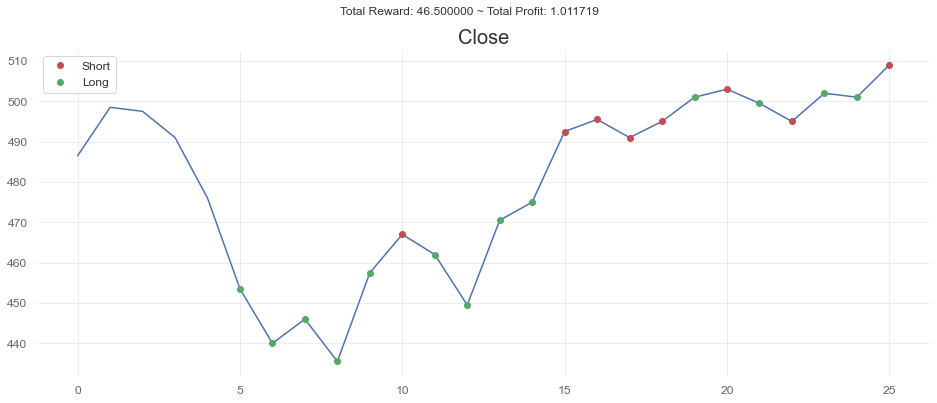

In [14]:
plt.figure(figsize=(16, 6))
env.render_Close()#將「環境」畫出來

↓↓↓ 台積電(2330)在使用交易策略(Long Or Short)後，隔日早上平倉時的盈虧(未含手續費) ↓↓↓


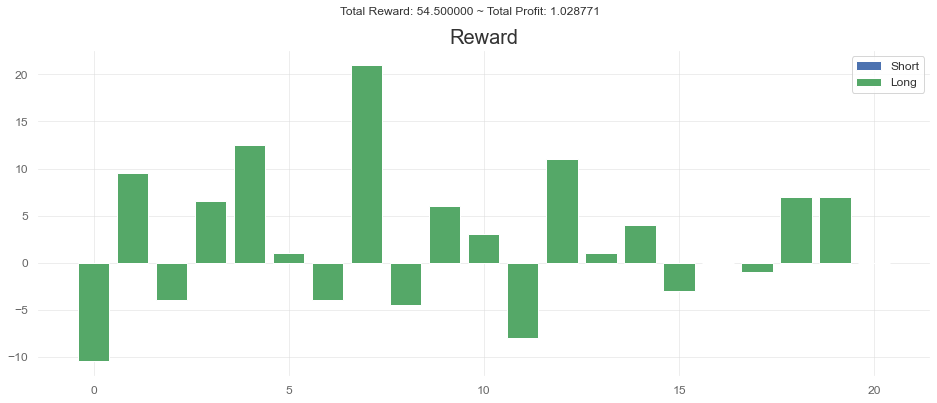

In [17]:
plt.figure(figsize=(16, 6))
env.render_Reward()

↓↓↓ 根據預測出的交易策略交易台積電(2330)，所得到的累積利潤(含手續費) ↓↓↓


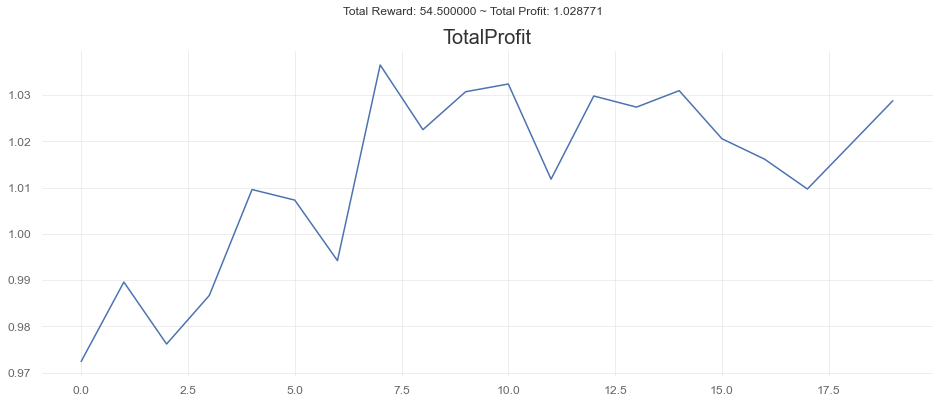

In [18]:
plt.figure(figsize=(16, 6))
env.render_TotalProfit()

# ------------------------------------------------

# 不同技術分析合併進行資料萃取，需要轉換矩陣格式，解釋如下：

In [89]:
a = np.array([
    [
        [1,2,3,4,5,6],
        [2,4,5,6,5,6],
        [2,4,5,6,5,6],
        [2,4,5,6,5,6]
    ]
])
#-----------------------
b = np.array([
    [
        [1,2],[3,4],[5,6]
    ],
    [
        [2,4],[5,6],[5,6]
    ],
    [
        [2,4],[5,6],[5,6]
    ],
    [
        [2,4],[5,6],[5,6]
    ]
])
#-----------------------
print('目的：將原本矩陣a，變成矩陣b。因為在機器訓練時，需要讓機器意識到為兩組獨立的參數')
print('注意：入面組嘅大小必須相同，例如[1,2],[3,4]，但不可以[1,2],[3,4,5]\n\n')
print('第一個數字：大括號\n第二個數字：有四個打橫\n第三個數字：打橫入面有幾多個數字')
print(a.shape)
print(a,'\n')
print('第一個數字：有幾多大組嘅數字\n第二個數字：入面有幾多個小組\n第三個數字：每個小組入面有幾多個數字')
print(b.shape)
print(b)

目的：將原本矩陣a，變成矩陣b。因為在機器訓練時，需要讓機器意識到為兩組獨立的參數
注意：入面組嘅大小必須相同，例如[1,2],[3,4]，但不可以[1,2],[3,4,5]


第一個數字：大括號
第二個數字：有四個打橫
第三個數字：打橫入面有幾多個數字
(1, 4, 6)
[[[1 2 3 4 5 6]
  [2 4 5 6 5 6]
  [2 4 5 6 5 6]
  [2 4 5 6 5 6]]] 

第一個數字：有幾多大組嘅數字
第二個數字：入面有幾多個小組
第三個數字：每個小組入面有幾多個數字
(4, 3, 2)
[[[1 2]
  [3 4]
  [5 6]]

 [[2 4]
  [5 6]
  [5 6]]

 [[2 4]
  [5 6]
  [5 6]]

 [[2 4]
  [5 6]
  [5 6]]]
